## Wordification

Wordification [[1]](#fn1) is a propositionalization approach that uses text mining ideas to enable transformation  of relational data into a tabular form. Data instances are treated as documents while attribute values are treated as words. We use the implementation available in the `python-rdm` package, which offers utilities for loading the data from CSV files and from relational databases. The notebook demonstrates how wordification can transform a relational database into a single table which can then be modeled using traditional machine learning algorithms. We demonstrate an example based on the Michalski’s East-West trains challenge [[2]](#fn2), where the task is to learn a model explaining the characteristics of trains going east (or west).

---
<span id="fn1"> [1] Matic Perovšek, Anze Vavpetič, Janez Kranjc, Bojan Cestnik, and Nada Lavrač. Wordification: Propositionalization by unfolding relational data into bags of words. Expert Systems with Applications, 42(17-18):6442–6456, 2015. </span>

<span id="fn2"> [2] D. Michie, S. Muggleton, D. Page, and A. Srinivasan. To the international computing community: A new East-West challenge. Technical report, Oxford University, Computing laboratory, Oxford,UK, 1994. https://www.doc.ic.ac.uk/~shm/Datasets/Trains/ml-chall.ps </span>

----

First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install python-rdm==0.3.6
!pip -q install tabulate==0.8.7
!pip -q install requests==2.25.0
!pip -q install ipython==7.19.0

The trains dataset is available in the `python-rdm` repository and we get it from there.

In [2]:
import requests
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/trains.csv')
with open("data/trains.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/trains/cars.csv')
with open("data/cars.csv", "wb") as file:
    file.write(request.content)

The trains dataset is a relational database and consists of two tables (trains and cars) which are connected with the foreign key. In the CSV format in which the `trains` relational database is stored, the header consists of three rows. The first row declares attribute names. The second row declares attribute types in SQLite syntax (e.g., "integer" or "varchar"). The third row declares constraints such as primary and foreign keys using a simplified SQLite syntax. For example, `primary key` declares that a given column is the primary key, while `foreign key [table.column]` declares the foreign key relation between the given column and the specified table and column (the name of the table must be he same as the name of the file containing table data). The following snippet displays the first five rows of the `trains.csv` file and the first ten rows of the `cars.csv` file. The relationship between the two tables is that the `cars.tid` is a foreign key pointing to `trains.id`.

In [3]:
import csv
from IPython.display import HTML, display
import tabulate
with open('data/trains.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "trains"')
display(HTML(tabulate.tabulate(rows[:5], tablefmt='html', showindex=True)))

with open('data/cars.csv') as csvfile:
    rows = [row for row in csv.reader(csvfile)]
print('table "cars"')
display(HTML(tabulate.tabulate(rows[:10], tablefmt='html', showindex=True)))

table "trains"


0,id,direction
1,integer,varchar
2,primary key,
3,1,east
4,2,east


table "cars"


0,id,tid,position,shape,len,sides,roof,wheels,load_shape,load_num
1,integer,integer,integer,varchar,varchar,varchar,varchar,integer,varchar,integer
2,primary key,foreign key [trains.id],,,,,,,,
3,1,1,1,rectangle,short,not_double,none,2,circle,1
4,2,1,2,rectangle,long,not_double,none,3,hexagon,1
5,3,1,3,rectangle,short,not_double,peaked,2,triangle,1
6,4,1,4,rectangle,long,not_double,none,2,rectangle,3
7,5,2,1,rectangle,short,not_double,flat,2,circle,2
8,6,2,2,bucket,short,not_double,none,2,rectangle,1
9,7,2,3,u_shaped,short,not_double,none,2,triangle,1


`python-rdm` package implements the `DBContext` class which simplifies reading data from relational databases.
It can be connected to an instance of `CSVConnection` class to read relational data from CSV files in the format described above. The following code snippet establishes a CSV connection and specifies that the target table is _trains_ and the target attribute is _direction_ (east or west).

In [4]:
from rdm.db import DBContext, CSVConnection
connection = CSVConnection(['data/trains.csv','data/cars.csv'])
context = DBContext(connection, target_table='trains', target_att='direction')

Wordification implementation in `python-rdm` requires the `Table` data structure provided by the Orange data mining library. Using the provided converter, a wrapper for the wordification instance is first constructed. Then the wordification transforms relational instances into a tabular format. The parameter `word_att_length` specifies the maximal length of constructed words and thus controls the number of features returned by the transformation.

In [5]:
from rdm.db import OrangeConverter
from rdm.wrappers import Wordification
conv = OrangeConverter(context)
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=1)
wordificator.run()

The word (i.e. feature) weights can be computed using diferent weighting methods: binary, tf, and tf-idf. We can export the resulting dataset into the Weka's ARFF format or Orange's `Table` data structure, which can be used directly with the `scikit-learn` library. The following snippet computes the binary weights and prints out the constructed features.

In [6]:
from pprint import pprint
wordificator.calculate_weights(measure='binary')
trains_binary = wordificator.to_orange()
print(trains_binary.X.shape)
pprint([x.name for x in trains_binary.domain.attributes])

(20, 29)
['Cars_Len_Long',
 'Cars_Len_Short',
 'Cars_LoadNum_0',
 'Cars_LoadNum_1',
 'Cars_LoadNum_2',
 'Cars_LoadNum_3',
 'Cars_LoadShape_Circle',
 'Cars_LoadShape_Diamond',
 'Cars_LoadShape_Hexagon',
 'Cars_LoadShape_Rectangle',
 'Cars_LoadShape_Triangle',
 'Cars_Position_1',
 'Cars_Position_2',
 'Cars_Position_3',
 'Cars_Position_4',
 'Cars_Roof_Arc',
 'Cars_Roof_Flat',
 'Cars_Roof_Jagged',
 'Cars_Roof_None',
 'Cars_Roof_Peaked',
 'Cars_Shape_Bucket',
 'Cars_Shape_Ellipse',
 'Cars_Shape_Hexagon',
 'Cars_Shape_Rectangle',
 'Cars_Shape_UShaped',
 'Cars_Sides_Double',
 'Cars_Sides_NotDouble',
 'Cars_Wheels_2',
 'Cars_Wheels_3']


This is not the only option. If we increase the `word_att_length` to 2 and weight the words using the _tf-idf_ scheme, we get a much larger number of features. The following code snippet prints the first 20 features, now composed of two _attribute-value_ terms.

In [7]:
wordificator = Wordification(conv.target_Orange_table(), conv.other_Orange_tables(), context, word_att_length=2)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
trains_tfidf = wordificator.to_orange()
print(trains_tfidf.X.shape)
pprint([x.name for x in trains_tfidf.domain.attributes][:20])

(20, 256)
['Cars_Len_Long',
 'Cars_Len_Long__Cars_LoadNum_0',
 'Cars_Len_Long__Cars_LoadNum_1',
 'Cars_Len_Long__Cars_LoadNum_2',
 'Cars_Len_Long__Cars_LoadNum_3',
 'Cars_Len_Long__Cars_LoadShape_Circle',
 'Cars_Len_Long__Cars_LoadShape_Hexagon',
 'Cars_Len_Long__Cars_LoadShape_Rectangle',
 'Cars_Len_Long__Cars_LoadShape_Triangle',
 'Cars_Len_Long__Cars_Position_1',
 'Cars_Len_Long__Cars_Position_2',
 'Cars_Len_Long__Cars_Position_3',
 'Cars_Len_Long__Cars_Position_4',
 'Cars_Len_Long__Cars_Roof_Flat',
 'Cars_Len_Long__Cars_Roof_Jagged',
 'Cars_Len_Long__Cars_Roof_None',
 'Cars_Len_Long__Cars_Shape_Rectangle',
 'Cars_Len_Long__Cars_Sides_NotDouble',
 'Cars_Len_Long__Cars_Wheels_2',
 'Cars_Len_Long__Cars_Wheels_3']


Many of the created features can be eliminated because they are either constant, duplicated or contain little information about the target. The following code ranks features with the recursive feature elimination. The best 20 features are selected and used to create a dataset in the tabular format.

In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(trains_tfidf.X, trains_tfidf.Y)
X1 = trains_tfidf.X[:,selector.support_]

The datatset is now transformed into a format suitable for most of machine learning algorithms. We demonstrate this by building and visualizing a decision tree (since we have only 10 instances we will not perform any standard evaluation). 

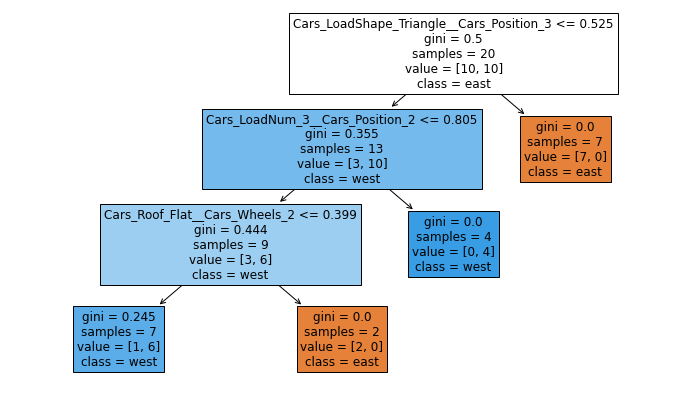

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
tree = DecisionTreeClassifier(min_samples_leaf=2)
tree.fit(X1, trains_tfidf.Y)
y_names = np.array([x.name for x in trains_tfidf.domain.attributes])[selector.support_]
_=plot_tree(tree, 
            feature_names=y_names, 
            filled=True, 
            fontsize=12, 
            class_names=[trains_tfidf.domain.class_var.str_val(i) for i in [0,1]],
            label='all')